# [Title]

## Preparation

- [Github link](google.com)
https://github.com/LZQ407/Spatial-Data-Science.git
- Number of words: ***

- Runtime: 0.5-1 hours (*Memory 10 GB, CPU Intel i7-10700 CPU @2.90GHz*)

- Coding environment: SDS Docker (or anything else)

- License: this notebook is made available under the [Creative Commons Attribution license](https://creativecommons.org/licenses/by/4.0/) (or other license that you like).

- Additional library *[libraries not included in SDS Docker or not used in this module]*:
    - **watermark**: A Jupyter Notebook extension for printing timestamps, version numbers, and hardware information.
    - ......

## Table of contents

1. [Introduction](#Introduction)

1. [Research questions](#Research-questions)

1. [Data](#Data)

1. [Methodology](#Methodology)

1. [Main Procession and Analysis](#Main-Procession-and-Analysis)

1. [Results and discussion](#Results-and-discussion)

1. [Conclusion](#Conclusion)

1. [References](#References)

## Introduction

[[ go back to the top ]](#Table-of-contents)

Road traffic collisions resulting in killed or seriously injured (KSI) casualties remain a key public health concern. Prior studies highlight two consistent environmental risks: darkness, which elevates fatality risk due to poor illumination (Plainis et al., 2006), and wet conditions, where precipitation and surface moisture increase crash risk (Becker et al., 2022). Research on Daylight Saving Time (DST) further shows that marginal changes in light exposure affect accident severity (James, 2022).

Yet, how these factors interact with speed limits and urban–rural contexts is less understood. Using Department for Transport (DfT) data from 2019–2023, this study examines  whether darkness and wetness raise the probability of KSI and whether their effects vary across local conditions.

## Research questions
Does darkness and wet road conditions increase the probability of a KSI (Killed/Seriously Injured) in UK road accidents from 2019 to 2023? 
Does this effect vary by speed band and urban/rural location?
[[ go back to the top ]](#Table-of-contents)

## Data

[[ go back to the top ]](#Table-of-contents)

This study uses the official Road Safety Data from the UK Department for Transport (DfT), merging the “last five years” and “provisional 2024” collision and casualty tables to cover 2019–2023. The collision table records accident-level attributes (date, location, conditions), while the casualty table details injury severity.  

The following variables were extracted as key inputs:  

| Variable | Source | Description | Data type |
|----------|--------|-------------|-----------|
| **Accident_Index** | Collision & casualty tables | Unique accident identifier, used to merge datasets | String (ID) |
| **Date** | Collision | Date of collision (parsed day-first, UK format) | Date / String (parsed to datetime) |
| **Light_Conditions** | Collision | Categorical: daylight, dark (with/without lighting) | Categorical (string / int code) |
| **Road_Surface_Conditions** | Collision | Categorical: dry, wet/damp, snow, ice, flood | Categorical (string / int code) |
| **Casualty_Severity** | Casualty | Fatal, serious, or slight injury | Categorical (string / int code) |
| **Speed_Limit** | Collision | Posted speed limit at crash site | Numeric (integer) |
| **Urban_or_Rural_Area** | Collision | Area classification (urban or rural) | Categorical (string / int code) |
| **Local_Authority_District (LAD)** | Collision | Local administrative unit | String (categorical code) |



| Variable                            | Type         | Description                                                             |Notes   |
|-------------------------------------|--------------|-------------------------------------------------------------------------|---|
| Burglary crime rate                 | Numeric      | The burglary rate of MSOAs. Used as dependent variables in regression.  |   |
| Temperature                         | Numeric      | The daytime temperature                                                 |   |
| Indicator of Inner or Outer London  | Categorical  | Whether the MSOA is in Inner London.                                    |   |
| ......  | ......  | ......                                    |   |

## Methodology 
[[ go back to the top ]](#Table-of-contents)
To answer the research question within the four-method limit, this study applies:

Descriptive statistics – Monthly trends (2019–2023) of collisions and KSI per 100 collisions.

Relative risk (RR) – Comparing Dark vs. Day and Wet vs. Dry with 95% CIs, stratified by speed bands and urban/rural context.

Panel regression (Two-Way FE GLM) – Binomial GLM on LAD–month panel with fixed effects, estimating links between dark/wet shares and KSI rate.

DST event study – Using the spring Daylight Saving Time shift as an exogenous change in light exposure to test short-term impacts on severity.


In [2]:
## pip install graphviz (If you want to draw the procession figure plz install this package and run next code if not you can jump this step)

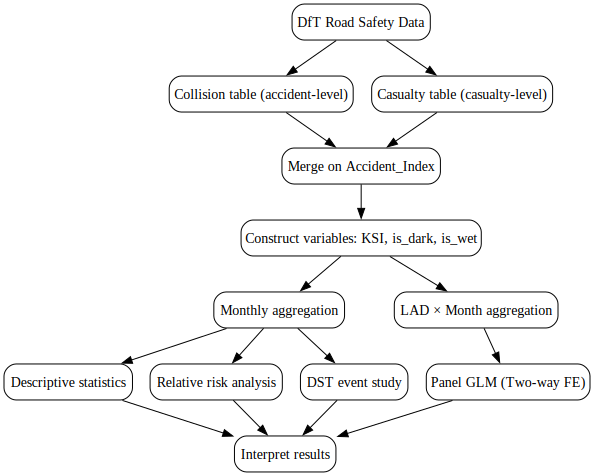

In [3]:
##Optional choices for the Procession Figure
from graphviz import Digraph

dot = Digraph(comment='Data & Methods Flow')
dot.attr('node', shape='box', style='rounded')

dot.node('A', 'DfT Road Safety Data')
dot.node('B', 'Collision table (accident-level)')
dot.node('C', 'Casualty table (casualty-level)')
dot.node('D', 'Merge on Accident_Index')
dot.node('E', 'Construct variables: KSI, is_dark, is_wet')
dot.node('F', 'Monthly aggregation')
dot.node('G', 'LAD × Month aggregation')
dot.node('H1', 'Descriptive statistics')
dot.node('H2', 'Relative risk analysis')
dot.node('H3', 'Panel GLM (Two-way FE)')
dot.node('H4', 'DST event study')
dot.node('I', 'Interpret results')

dot.edges(['AB','AC'])
dot.edge('B','D'); dot.edge('C','D')
dot.edge('D','E')
dot.edge('E','F'); dot.edge('E','G')
dot.edge('F','H1'); dot.edge('F','H2'); dot.edge('F','H4')
dot.edge('G','H3')
dot.edge('H1','I'); dot.edge('H2','I'); dot.edge('H3','I'); dot.edge('H4','I')

dot

## Main Procession and Analysis 
[[ go back to the top ]](#Table-of-contents)

In [2]:
# 1) Imports
import pandas as pd, numpy as np, glob, os
from pathlib import Path
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,4)
pd.set_option("display.max_columns", 200)

# 2) Paths
data_dir = Path("Safety Data")
assert data_dir.exists(), f"Folder not found: {data_dir}"

OUT_DIR = data_dir/"Outputs_CASA0006"
OUT_DIR.mkdir(exist_ok=True)

# 3) Data processing
def pick_latest(patterns):
    hits=[]
    for pat in patterns: hits+=glob.glob(str(data_dir/pat))
    if not hits: raise FileNotFoundError("Missing: " + " | ".join(patterns))
    return max(hits, key=os.path.getmtime)

def read_csv_robust(path):
    for enc in ["utf-8","utf-8-sig","cp1252","latin1"]:
        try:
            df = pd.read_csv(path, dtype=str, encoding=enc, engine="c")
            df.columns = df.columns.str.replace('\ufeff','',regex=False).str.strip()
            return df
        except Exception:
            try:
                df = pd.read_csv(path, dtype=str, encoding=enc, engine="python", on_bad_lines="skip")
                df.columns = df.columns.str.replace('\ufeff','',regex=False).str.strip()
                return df
            except Exception:
                continue
    raise RuntimeError(f"Failed to read: {path}")

# 4) Load the four files
p_coll_last5   = pick_latest(["*collision*last*5*year*.csv"])
p_coll_mid2024 = pick_latest(["*collision*provisional*2024*.csv"])
p_cas_last5    = pick_latest(["*casualty*last*5*year*.csv"])
p_cas_mid2024  = pick_latest(["*casualty*provisional*2024*.csv"])

print("Files:\n -", p_coll_last5, "\n -", p_coll_mid2024, "\n -", p_cas_last5, "\n -", p_cas_mid2024)

collisions_raw = pd.concat([read_csv_robust(p_coll_last5),
                            read_csv_robust(p_coll_mid2024)], ignore_index=True)
casualties_raw = pd.concat([read_csv_robust(p_cas_last5),
                            read_csv_robust(p_cas_mid2024)], ignore_index=True)

print("Collisions shape:", collisions_raw.shape)
print("Casualties shape:", casualties_raw.shape)


Files:
 - Safety Data/dft-road-casualty-statistics-collision-last-5-years.csv 
 - Safety Data/dft-road-casualty-statistics-collision-provisional-mid-year-unvalidated-2024 - dft-road-casualty-statistics-collision-provisional-mid-year-unvalidated-2024.csv 
 - Safety Data/dft-road-casualty-statistics-casualty-last-5-years.csv 
 - Safety Data/dft-road-casualty-statistics-collision-provisional-mid-year-unvalidated-2024 - dft-road-casualty-statistics-collision-provisional-mid-year-unvalidated-2024.csv
Collisions shape: (566791, 44)
Casualties shape: (712115, 59)


In [3]:
# 5) Harmonise essentials + normalize accident index

# Function to standardize accident index:
# - force to string
# - uppercase
# - strip spaces
# - remove all non-alphanumeric characters
def norm_idx(s):
    return (s.astype(str)
              .str.upper()
              .str.strip()
              .str.replace(r'[^0-9A-Z]', '', regex=True))

# Function to "take" a column:
# - loop through candidate names (cs)
# - if one exists in df, copy it to a new uniform name
# - if none found, create column with NA
def take(df, cs, new):
    for c in cs:
        if c in df.columns:
            df[new] = df[c]; return
    df[new] = pd.NA

# Ensure both datasets have standardized keys
take(collisions_raw, ["Accident_Index","accident_index","ï»¿Accident_Index"], "accident_index")
take(collisions_raw, ["Date","date"], "date")
take(casualties_raw, ["Accident_Index","accident_index","ï»¿Accident_Index"], "accident_index")
take(casualties_raw, ["Casualty_Severity","casualty_severity"], "cas_sev")

# Create normalized accident index in both tables
collisions_raw["accident_index_n"] = norm_idx(collisions_raw["accident_index"])
casualties_raw["accident_index_n"] = norm_idx(casualties_raw["accident_index"])

# Parse UK dates (day-first format), drop rows with missing index or date
collisions_raw["date"] = pd.to_datetime(collisions_raw["date"], errors="coerce", dayfirst=True)
collisions_raw = collisions_raw.dropna(subset=["accident_index_n","date"]).copy()

print("Collisions rows:", len(collisions_raw))
print("Unique accident_index_n:", collisions_raw["accident_index_n"].nunique())
print("Date range:", collisions_raw["date"].min(), "to", collisions_raw["date"].max())

print("\nCasualties rows:", len(casualties_raw))
print("Unique accident_index_n:", casualties_raw["accident_index_n"].nunique())
print("Casualty severity top values:")
print(casualties_raw["cas_sev"].value_counts(dropna=False).head(10))


Collisions rows: 566791
Unique accident_index_n: 520085
Date range: 2019-01-01 00:00:00 to 2024-06-30 00:00:00

Casualties rows: 712115
Unique accident_index_n: 520085
Casualty severity top values:
cas_sev
3      536615
2      120688
NaN     46707
1        8105
Name: count, dtype: int64


Collisions total: 566791
Collisions with >=1 KSI: 117037
Share of accidents with KSI: 20.649057589128976 %

KSI count distribution per accident (top 10):
ksi
0     449754
1     108017
2       7116
3       1360
4        368
5        121
6         31
7         13
8          7
13         1
Name: count, dtype: int64


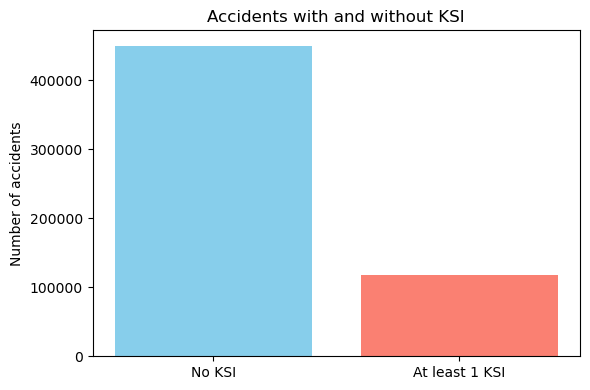

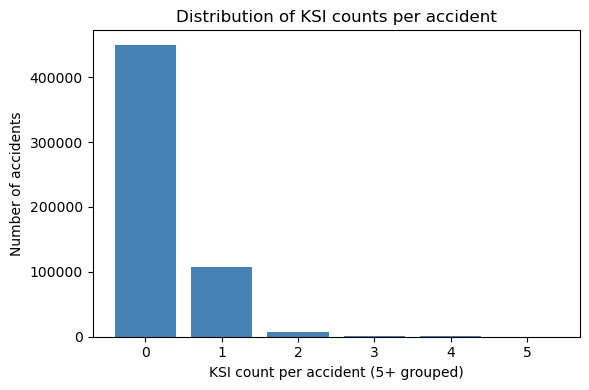

In [4]:
# 6) Build KSI per accident
cs = casualties_raw["cas_sev"].astype(str).str.strip()
cs_num = pd.to_numeric(cs, errors="coerce")
is_ksi = cs_num.isin([1,2]) | cs.str.contains("Fatal|Serious", case=False, na=False)
ksi_by = casualties_raw.loc[is_ksi].groupby("accident_index_n", observed=False) \
         .size().rename("ksi").reset_index()

acc = collisions_raw.merge(ksi_by, on="accident_index_n", how="left")
acc["ksi"] = pd.to_numeric(acc["ksi"], errors="coerce").fillna(0).astype(int)

# Summary checks
print("Collisions total:", len(acc))
print("Collisions with >=1 KSI:", (acc["ksi"]>0).sum())
print("Share of accidents with KSI:", (acc["ksi"]>0).mean()*100, "%")

# Show distribution of KSI counts per accident
print("\nKSI count distribution per accident (top 10):")
print(acc["ksi"].value_counts().head(10))

# Quick preview
acc[["accident_index_n","date","ksi"]].head(5)

# Visualization: binary split (KSI vs No KSI)
has_ksi = (acc["ksi"] > 0).sum()
no_ksi  = (acc["ksi"] == 0).sum()

plt.figure(figsize=(6,4))
plt.bar(["No KSI","At least 1 KSI"], [no_ksi, has_ksi], color=["skyblue","salmon"])
plt.title("Accidents with and without KSI")
plt.ylabel("Number of accidents")
plt.tight_layout()
plt.show()

# Visualization: distribution of KSI counts per accident
ksi_counts = acc["ksi"].clip(upper=5)  # group 5+ together
dist = ksi_counts.value_counts().sort_index()

plt.figure(figsize=(6,4))
plt.bar(dist.index.astype(str), dist.values, color="steelblue")
plt.title("Distribution of KSI counts per accident")
plt.xlabel("KSI count per accident (5+ grouped)")
plt.ylabel("Number of accidents")
plt.tight_layout()
plt.show()

In [5]:
# 7) Robust field picking
def pick_col(df, preferred, keywords):
    for name in preferred:
        if name in df.columns: return df[name], name
    lowmap = {c: c.lower() for c in df.columns}
    for col, low in lowmap.items():
        if any(k in low for k in keywords):
            return df[col], col
    return pd.Series(pd.NA, index=df.index), None

light_ser,  light_src  = pick_col(acc, ["Light_Conditions","light_conditions","light"], ["light"])
surf_ser,   surf_src   = pick_col(acc, ["Road_Surface_Conditions","road_surface_conditions","surface"], ["surface","road surface"])
urban_ser,  urban_src  = pick_col(acc, ["Urban_or_Rural_Area","Urban_or_Rural","urban_or_rural_area","urban_rural"], ["urban","rural"])
speed_ser,  speed_src  = pick_col(acc, ["Speed_Limit","Speed_limit","speed_limit"], ["speed"])
roadc_ser,  roadc_src  = pick_col(acc, ["1st_Road_Class","First_Road_Class","first_road_class","road_class"], ["road","class"])
lad_ser,    lad_src    = pick_col(acc, ["Local_Authority_(District)","Local_Authority_District","local_authority_district","lad"], ["local","authority","district","lad"])
time_ser,   time_src   = pick_col(acc, ["Time","time"], ["time"])

print(f"[Using columns] light= {light_src or 'N/A'} | surface= {surf_src or 'N/A'} | "
      f"urban_rural= {urban_src or 'N/A'} | speed_limit= {speed_src or 'N/A'} | "
      f"road_class= {roadc_src or 'N/A'} | LAD= {lad_src or 'N/A'} | time= {time_src or 'N/A'}")


[Using columns] light= light_conditions | surface= road_surface_conditions | urban_rural= urban_or_rural_area | speed_limit= speed_limit | road_class= first_road_class | LAD= local_authority_district | time= time


In [6]:
# 8) Flags + detailed categories
def to_dark(series):
    s = series.astype(str).str.lower()
    num = pd.to_numeric(s, errors="coerce")
    return ((num.isin([4,5,6,7]) | s.str.contains("dark", na=False)) &
            ~s.str.contains("daylight", na=False)).astype(int)

def to_wet(series):
    s = series.astype(str).str.lower()
    num = pd.to_numeric(s, errors="coerce")
    return ((num.isin([2,3,4,5,6,7]) | s.str.contains("wet|damp|snow|frost|ice|flood|mud|oil", na=False)) &
            ~s.str.contains("dry", na=False)).astype(int)

def map_light_detail(s, n):
    if s.isna().all():
        return pd.Categorical(["Other"]*n, categories=["Daylight","Dark—lights lit","Dark—unlit","Dark—no lighting","Dark—unknown","Other"], ordered=True)
    t = s.astype(str).str.lower().str.strip()
    num = pd.to_numeric(t, errors="coerce")
    out = np.select(
        [
            t.str.contains("day", na=False) | (num==1),
            t.str.contains("unlit", na=False) | (num==5),
            t.str.contains("no lighting", na=False) | (num==6),
            t.str.contains("lit", na=False) | (num==4),
            (num==7)
        ],
        ["Daylight","Dark—unlit","Dark—no lighting","Dark—lights lit","Dark—unknown"],
        default="Other"
    )
    return pd.Categorical(out, categories=["Daylight","Dark—lights lit","Dark—unlit","Dark—no lighting","Dark—unknown","Other"], ordered=True)

def map_surface_detail(s, n):
    if s.isna().all():
        return pd.Categorical(["Other"]*n, categories=["Dry","Wet—damp","Snow","Frost/ice","Flood","Other"], ordered=True)
    t = s.astype(str).str.lower().str.strip()
    num = pd.to_numeric(t, errors="coerce")
    out = np.select(
        [
            t.str.contains("dry", na=False) | (num==1),
            t.str.contains("wet|damp", na=False) | (num==2),
            t.str.contains("snow", na=False) | (num==3),
            t.str.contains("frost|ice", na=False) | (num==4),
            t.str.contains("flood", na=False) | (num==5),
            t.str.contains("oil|mud", na=False) | (num.isin([6,7]))
        ],
        ["Dry","Wet—damp","Snow","Frost/ice","Flood","Other"],
        default="Other"
    )
    return pd.Categorical(out, categories=["Dry","Wet—damp","Snow","Frost/ice","Flood","Other"], ordered=True)

acc["is_dark"]  = to_dark(light_ser.fillna(""))
acc["is_wet"]   = to_wet(surf_ser.fillna(""))
acc["light_detail"]   = map_light_detail(light_ser, len(acc))
acc["surface_detail"] = map_surface_detail(surf_ser, len(acc))

def to_urban2(s):
    t = s.astype(str).str.lower()
    num = pd.to_numeric(t, errors="coerce")
    return np.where((num==2)|t.str.contains("rural", na=False), "Rural",
           np.where((num==1)|t.str.contains("urban", na=False), "Urban", "Unknown"))

def band_speed2(x):
    v = pd.to_numeric(x, errors="coerce")
    bins = pd.cut(v, bins=[-1,25,35,45,55,65,999],
                  labels=["≤25","30–35","40–45","50–55","60–65","70+"], right=True)
    return bins.astype(str).fillna("Unknown")

acc["urban_rural2"] = to_urban2(urban_ser)
acc["speed_band2"]  = band_speed2(speed_ser)
acc["road_class2"]  = roadc_ser.astype(str).str.strip().replace({"1":"Motorway","2":"A","3":"B","4":"Minor"})
acc["lad2"]         = lad_ser.astype(str).fillna("Unknown")

# 9) Restrict to 2019–2023
acc = acc[(acc["date"] >= "2019-01-01") & (acc["date"] < "2024-01-01")].copy()

Monthly panel shape: (60, 6)
First few rows:
     month  collisions   ksi  ksi_per_100_collisions       date  moy
0  2019-01        9371  2032               21.683918 2019-01-01    1
1  2019-02        8838  1933               21.871464 2019-02-01    2
2  2019-03        9427  2100               22.276440 2019-03-01    3
3  2019-04        8899  2145               24.103832 2019-04-01    4
4  2019-05        9758  2307               23.642140 2019-05-01    5

Overall average KSI per 100 collisions: 24.77


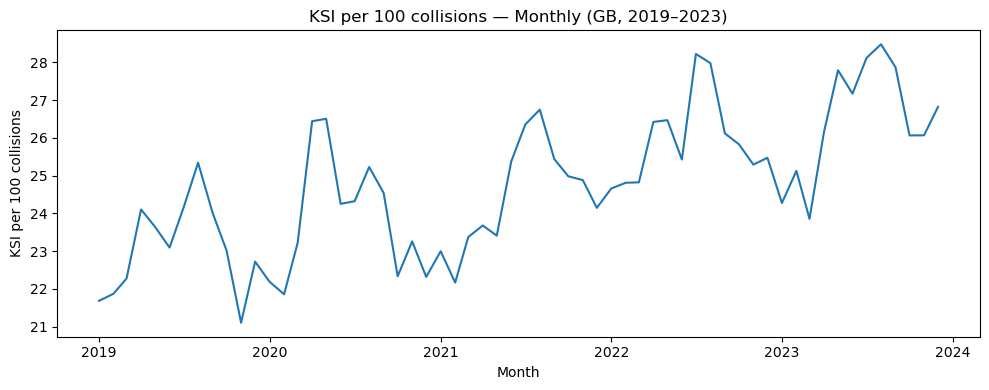

In [7]:
# 10) Monthly panel & trend
acc["month"] = acc["date"].dt.to_period("M").astype(str)
monthly = acc.groupby("month", as_index=False, observed=False).agg(
    collisions=("accident_index_n","nunique"),
    ksi=("ksi","sum")
)
monthly["ksi_per_100_collisions"] = 100 * monthly["ksi"] / monthly["collisions"]
monthly["date"] = pd.to_datetime(monthly["month"] + "-01")
monthly["moy"]  = monthly["date"].dt.month
monthly.to_csv(OUT_DIR/"monthly_panel_extended.csv", index=False)

plt.figure()
plt.plot(monthly["date"], monthly["ksi_per_100_collisions"])
plt.title("KSI per 100 collisions — Monthly (GB, 2019–2023)")
plt.xlabel("Month"); plt.ylabel("KSI per 100 collisions")
plt.tight_layout()
plt.savefig(OUT_DIR/"monthly_trend_2019_2023.png", dpi=160); plt.close()

print("Monthly panel shape:", monthly.shape)
print("First few rows:")
print(monthly.head())

print("\nOverall average KSI per 100 collisions:", monthly["ksi_per_100_collisions"].mean().round(2))

plt.figure()
plt.plot(monthly["date"], monthly["ksi_per_100_collisions"])
plt.title("KSI per 100 collisions — Monthly (GB, 2019–2023)")
plt.xlabel("Month"); plt.ylabel("KSI per 100 collisions")
plt.tight_layout()
plt.show()


To examine temporal patterns, monthly aggregates were constructed (2019–2023), including collision counts, KSI casualties, and KSI per 100 collisions. The average rate over the period is 24.8 per 100 collisions. The time series shows (i) seasonal fluctuations with recurrent peaks in spring/summer, (ii) a modest upward drift from ~22 to ~28 per 100 collisions, and (iii) persistent variability, indicating rising severity risk despite stable collision numbers.

=== Quadrant results (collisions, KSI, rate) ===
            collisions    ksi  ksi_per_100
label                                     
Day & Dry       295252  69038    23.382737
Day & Wet        76560  17978    23.482236
Dark & Dry       84934  23228    27.348294
Dark & Wet       63338  18549    29.285737


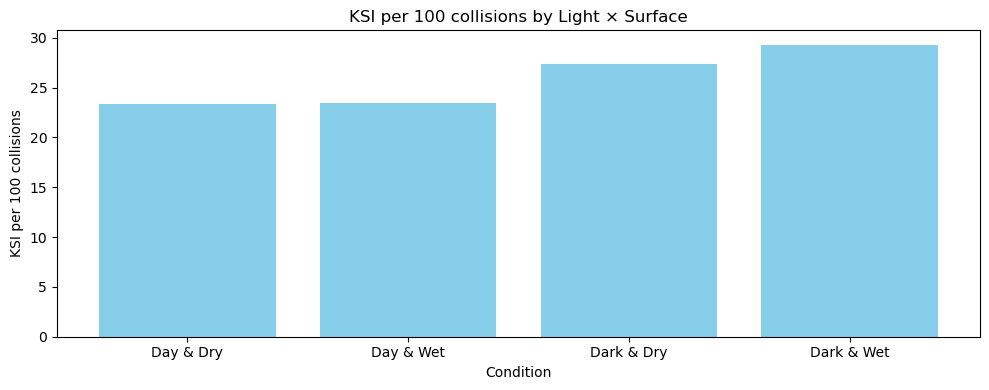

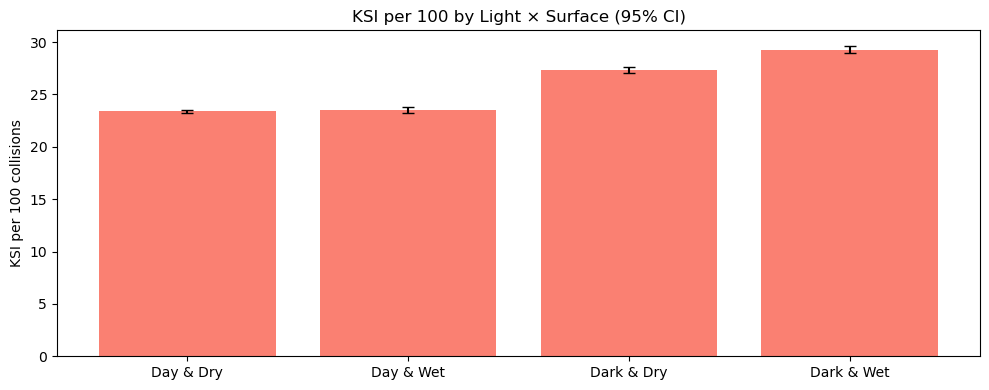

In [8]:
# 11) Quadrants + CI bars
import numpy as np
import matplotlib.pyplot as plt

# 1. Group by darkness (is_dark) and wetness (is_wet)
quad = acc.groupby(["is_dark","is_wet"], as_index=False, observed=False).agg(
    collisions=("accident_index_n","nunique"),
    ksi=("ksi","sum")
)

# 2. Compute KSI per 100 collisions
quad["ksi_per_100"] = 100 * quad["ksi"] / quad["collisions"]

# 3. Add readable labels
quad["label"] = quad.apply(
    lambda r: ("Dark" if r.is_dark else "Day") + " & " + ("Wet" if r.is_wet else "Dry"),
    axis=1
)

# 4. Save to CSV
quad.to_csv(OUT_DIR/"quadrant_rates.csv", index=False)

# 5. Reorder quadrants to a logical sequence
order = ["Day & Dry","Day & Wet","Dark & Dry","Dark & Wet"]
qp = quad.set_index("label").reindex(order)

# --- Display results table
print("=== Quadrant results (collisions, KSI, rate) ===")
print(qp[["collisions","ksi","ksi_per_100"]])

# 6. Bar plot of KSI per 100 collisions
plt.figure()
plt.bar(qp.index.tolist(), qp["ksi_per_100"].values, color="skyblue")
plt.title("KSI per 100 collisions by Light × Surface")
plt.xlabel("Condition")
plt.ylabel("KSI per 100 collisions")
plt.tight_layout()
plt.show()

# 7. Compute 95% confidence intervals for proportions
p = (qp["ksi"]/qp["collisions"]).values     # observed proportion
N = qp["collisions"].values                 # number of trials
se = np.sqrt(np.maximum(p*(1-p)/np.maximum(N,1), 0))  # standard error
y = 100 * p
yerr = 100 * 1.96 * se                       # 95% CI range

# 8. Bar plot with CI error bars
plt.figure()
plt.bar(qp.index.tolist(), y, yerr=yerr, capsize=4, color="salmon")
plt.title("KSI per 100 by Light × Surface (95% CI)")
plt.ylabel("KSI per 100 collisions")
plt.tight_layout()
plt.show()

Accidents were grouped into four quadrants by light and surface conditions. Results show: Day & Dry (baseline, 23.4 KSI per 100 collisions), Day & Wet (23.5, little change), Dark & Dry (27.3, higher due to visibility loss), and Dark & Wet (29.3, highest risk). Bar charts confirm this stepwise increase, with confidence intervals showing that elevated risks under dark conditions—especially Dark & Wet—are statistically significant.

In [9]:
# 12) Risk table (RR)
import math
def risk_table_from_acc(df, flag_col, name1, name0):
    t = df.groupby(flag_col, observed=False).agg(
        collisions=("accident_index_n","nunique"),
        ksi=("ksi","sum")
    ).reindex([0,1], fill_value=0)
    c0,k0 = int(t.loc[0,"collisions"]), int(t.loc[0,"ksi"])
    c1,k1 = int(t.loc[1,"collisions"]), int(t.loc[1,"ksi"])
    p0 = k0/c0 if c0>0 else np.nan
    p1 = k1/c1 if c1>0 else np.nan
    rr = p1/p0 if (p0 and p0>0) else np.nan
    if all(x>0 for x in [c0,c1,k0,k1]):
        se = math.sqrt((1/k1 - 1/c1) + (1/k0 - 1/c0))
        lo, hi = np.exp(np.log(rr) - 1.96*se), np.exp(np.log(rr) + 1.96*se)
    else:
        lo, hi = np.nan, np.nan
    return pd.DataFrame([{
        "contrast": f"{name1} vs {name0}",
        "p1": p1, "p0": p0, "RR": rr, "RR_95CI_low": lo, "RR_95CI_high": hi,
        "n1_collisions": c1, "n1_ksi": k1, "n0_collisions": c0, "n0_ksi": k0
    }])

risk_df = pd.concat([
    risk_table_from_acc(acc, "is_dark", "Darkness", "Daylight"),
    risk_table_from_acc(acc, "is_wet",  "Wet/Adverse", "Dry")
], ignore_index=True)
risk_df.to_csv(OUT_DIR/"risk_table.csv", index=False)

print("=== Relative Risk table ===")
print(risk_df[["contrast","p1","p0","RR","RR_95CI_low","RR_95CI_high"]])


=== Relative Risk table ===
               contrast        p1        p0        RR  RR_95CI_low  \
0  Darkness vs Daylight  0.281759  0.234032  1.203933     1.191962   
1    Wet/Adverse vs Dry  0.261097  0.242686  1.075863     1.064677   

   RR_95CI_high  
0      1.216025  
1      1.087167  


Relative risk (RR) analysis shows that collisions in darkness have a KSI probability of 28.2% vs 23.4% in daylight, giving RR=1.20 (95% CI: 1.19–1.22). For wet/adverse surfaces, the probability is 26.1% vs 24.3% on dry roads, with RR=1.08 (95% CI: 1.06–1.09). Both effects are statistically significant, but darkness exerts the stronger influence on collision severity.

=== Light detail rates ===
       light_detail  collisions    ksi  ksi_per_100
0          Daylight      371798  87011    23.402762
1   Dark—lights lit      107321  27692    25.802965
2        Dark—unlit        3806   1132    29.742512
3  Dark—no lighting       26988  11142    41.285016
4      Dark—unknown       10157   1811    17.830068
5             Other          14      5    35.714286

=== Surface detail rates ===
  surface_detail  collisions    ksi  ksi_per_100
0            Dry      371776  91510    24.614284
1       Wet—damp      131404  34447    26.214575
2           Snow        1347    310    23.014105
3      Frost/ice        6341   1529    24.112916
4          Flood         806    241    29.900744
5          Other        8410    756     8.989298


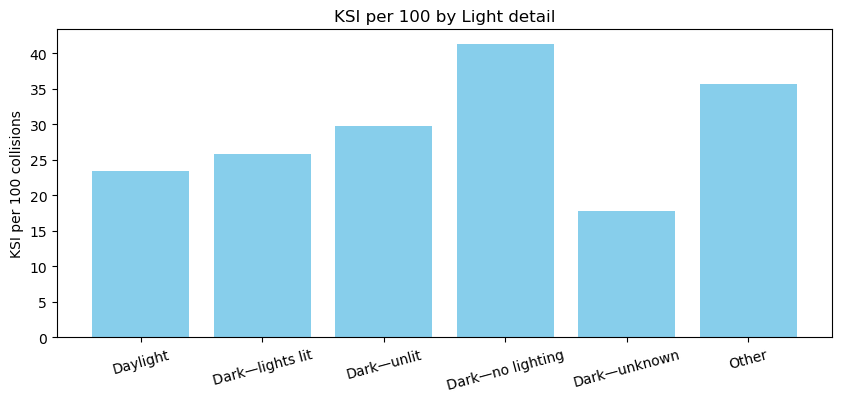

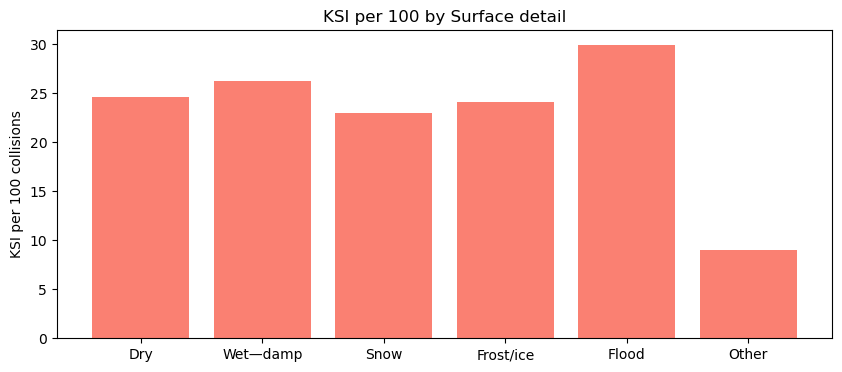

In [10]:
# 13) Light/Surface detailed rates & bars
def table_rate(df, by):
    g = df.groupby(by, as_index=False, observed=False).agg(
        collisions=("accident_index_n","nunique"),
        ksi=("ksi","sum")
    )
    g["ksi_per_100"] = 100*g["ksi"]/g["collisions"]
    return g

light_tab   = table_rate(acc, "light_detail")
surface_tab = table_rate(acc, "surface_detail")
light_tab.to_csv(OUT_DIR/"light_detail_rates.csv", index=False)
surface_tab.to_csv(OUT_DIR/"surface_detail_rates.csv", index=False)

plt.figure()
plt.bar(light_tab["light_detail"], light_tab["ksi_per_100"]); plt.xticks(rotation=15)
plt.title("KSI per 100 by Light detail"); plt.ylabel("KSI per 100 collisions")
plt.tight_layout(); plt.savefig(OUT_DIR/"light_detail_bars.png", dpi=160); plt.close()

plt.figure()
plt.bar(surface_tab["surface_detail"], surface_tab["ksi_per_100"])
plt.title("KSI per 100 by Surface detail"); plt.ylabel("KSI per 100 collisions")
plt.tight_layout(); plt.savefig(OUT_DIR/"surface_detail_bars.png", dpi=160); plt.close()

print("=== Light detail rates ===")
print(light_tab)

print("\n=== Surface detail rates ===")
print(surface_tab)

plt.figure()
plt.bar(light_tab["light_detail"], light_tab["ksi_per_100"], color="skyblue")
plt.xticks(rotation=15)
plt.title("KSI per 100 by Light detail")
plt.ylabel("KSI per 100 collisions")
plt.show()

plt.figure()
plt.bar(surface_tab["surface_detail"], surface_tab["ksi_per_100"], color="salmon")
plt.title("KSI per 100 by Surface detail")
plt.ylabel("KSI per 100 collisions")
plt.show()

Disaggregated analysis shows clear heterogeneity. Under light conditions, daylight has the lowest severity (23.4 KSI/100 collisions). Risk rises with reduced lighting: lit dark (25.8), unlit dark (29.7), and no lighting peaks at 41.3, nearly double daylight, confirming inadequate lighting as a major risk factor.

For surfaces, dry roads form the baseline (24.6). Wet/damp slightly increase risk (26.2), while snow/ice remain near baseline. Flooded roads are most hazardous (29.9), highlighting the extreme danger of floods. Overall, poor lighting and flooding sharply elevate KSI risk, while moderate conditions have smaller effects.

In [11]:
# 14) Stratified RR
def rr_by_stratum(df, strat_col, flag_col, name1, name0):
    rows=[]
    for k,g in df.groupby(strat_col, observed=False):
        t = g.groupby(flag_col, observed=False).agg(
            collisions=("accident_index_n","nunique"),
            ksi=("ksi","sum")
        ).reindex([0,1], fill_value=0)
        c0,k0 = int(t.loc[0,"collisions"]), int(t.loc[0,"ksi"])
        c1,k1 = int(t.loc[1,"collisions"]), int(t.loc[1,"ksi"])
        p0 = k0/c0 if c0>0 else np.nan
        p1 = k1/c1 if c1>0 else np.nan
        rr = p1/p0 if (p0 and p0>0) else np.nan
        if all(x>0 for x in [c0,c1,k0,k1]):
            se = math.sqrt((1/k1-1/c1)+(1/k0-1/c0))
            lo,hi = np.exp(np.log(rr)-1.96*se), np.exp(np.log(rr)+1.96*se)
        else:
            lo,hi = np.nan,np.nan
        rows.append({strat_col:str(k),"contrast":f"{name1} vs {name0}","RR":rr,"RR_low":lo,"RR_high":hi,"n0":c0,"n1":c1})
    return pd.DataFrame(rows)

rr_dark_by_speed  = rr_by_stratum(acc, "speed_band2",  "is_dark", "Dark","Day")
rr_dark_by_urban  = rr_by_stratum(acc, "urban_rural2", "is_dark", "Dark","Day")
rr_wet_by_speed   = rr_by_stratum(acc, "speed_band2",  "is_wet",  "Wet","Dry")
rr_wet_by_urban   = rr_by_stratum(acc, "urban_rural2", "is_wet",  "Wet","Dry")

rr_dark_by_speed.to_csv (OUT_DIR/"rr_dark_by_speed.csv", index=False)
rr_dark_by_urban.to_csv (OUT_DIR/"rr_dark_by_urban.csv", index=False)
rr_wet_by_speed.to_csv  (OUT_DIR/"rr_wet_by_speed.csv",  index=False)
rr_wet_by_urban.to_csv  (OUT_DIR/"rr_wet_by_urban.csv",  index=False)

print("=== Darkness RR by Speed Band ===")
display(rr_dark_by_speed)

print("\n=== Darkness RR by Urban/Rural ===")
display(rr_dark_by_urban)

print("\n=== Wetness RR by Speed Band ===")
display(rr_wet_by_speed)

print("\n=== Wetness RR by Urban/Rural ===")
display(rr_wet_by_urban)


=== Darkness RR by Speed Band ===


,speed_band2,contrast,RR,RR_low,RR_high,n0,n1
0,30–35,Dark vs Day,1.254865,1.236964,1.273024,207326,81634
1,40–45,Dark vs Day,1.303850,1.263698,1.345277,31861,12942
2,50–55,Dark vs Day,1.174432,1.125988,1.224960,15787,6087
3,60–65,Dark vs Day,1.078795,1.056469,1.101593,45906,17301
4,70+,Dark vs Day,1.288888,1.240876,1.338758,19572,9476
5,nan,Dark vs Day,2.538462,0.685257,9.403456,66,26
6,≤25,Dark vs Day,1.113053,1.076348,1.151009,51294,20806



=== Darkness RR by Urban/Rural ===


,urban_rural2,contrast,RR,RR_low,RR_high,n0,n1
0,Rural,Dark vs Day,1.180419,1.163214,1.197878,122492,45367
1,Unknown,Dark vs Day,1.118056,0.533844,2.341599,69,24
2,Urban,Dark vs Day,1.244193,1.227671,1.260937,249251,102881



=== Wetness RR by Speed Band ===


,speed_band2,contrast,RR,RR_low,RR_high,n0,n1
0,30–35,Wet vs Dry,1.085600,1.069019,1.102438,216330,72630
1,40–45,Wet vs Dry,1.049966,1.015951,1.085120,31743,13060
2,50–55,Wet vs Dry,0.980164,0.938687,1.023474,15177,6697
3,60–65,Wet vs Dry,0.878458,0.860513,0.896778,40445,22762
4,70+,Wet vs Dry,0.987139,0.948791,1.027037,19125,9923
5,nan,Wet vs Dry,0.454545,0.059114,3.495133,70,22
6,≤25,Wet vs Dry,1.047013,1.007985,1.087554,57296,14804



=== Wetness RR by Urban/Rural ===


,urban_rural2,contrast,RR,RR_low,RR_high,n0,n1
0,Rural,Wet vs Dry,0.973593,0.959274,0.988126,113685,54174
1,Unknown,Wet vs Dry,1.150327,0.564920,2.342372,66,27
2,Urban,Wet vs Dry,1.086573,1.070899,1.102476,266435,85697


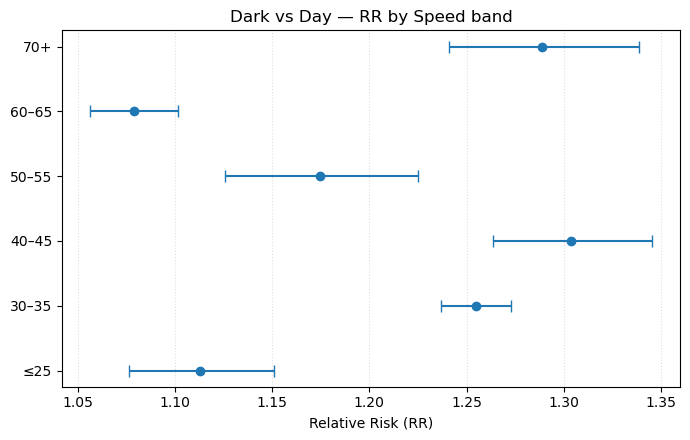

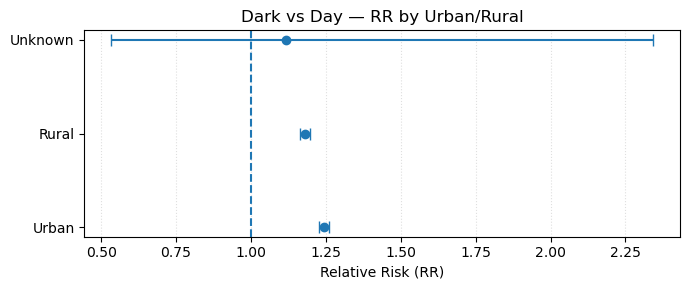

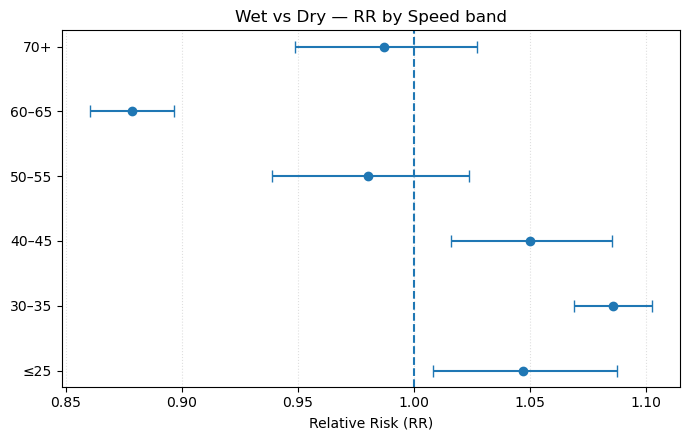

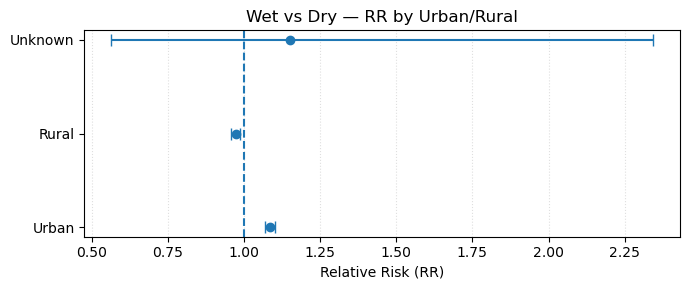

In [12]:
# Draw forest plots (RR with 95% CI) for stratified analyses:
#   - Darkness vs Day by Speed band
#   - Darkness vs Day by Urban/Rural
#   - Wet vs Dry by Speed band
#   - Wet vs Dry by Urban/Rural

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _prep_forest_df(df: pd.DataFrame, cat_col: str, desired_order=None, drop_vals=("nan","Unknown")):
    """Clean and order a stratified RR dataframe for plotting."""
    d = df.copy()
    # Coerce category to string and strip
    d[cat_col] = d[cat_col].astype(str).str.strip()
    # Drop bad/unknown if requested
    if drop_vals:
        d = d[~d[cat_col].isin(drop_vals)].copy()
    # If desired order is provided, use it; otherwise sort by RR descending
    if desired_order:
        # Keep only categories in desired order and reindex
        d = d.set_index(cat_col).reindex([c for c in desired_order if c in d[cat_col].tolist()]).dropna(subset=["RR"]).reset_index()
        d.rename(columns={"index": cat_col}, inplace=True)
    else:
        d = d.sort_values("RR", ascending=False)
    # Ensure numeric
    for c in ["RR","RR_low","RR_high"]:
        d[c] = pd.to_numeric(d[c], errors="coerce")
    # Drop rows with missing RR or CI
    d = d.dropna(subset=["RR","RR_low","RR_high"])
    return d

def forest_plot(df: pd.DataFrame, cat_col: str, title: str, out_png: str):
    """Make a horizontal forest plot with RR and 95% CI."""
    y = np.arange(len(df))
    rr = df["RR"].values
    lo = df["RR_low"].values
    hi = df["RR_high"].values
    xerr = np.vstack([rr - lo, hi - rr])

    plt.figure(figsize=(7, 0.5*len(df) + 1.5))
    plt.errorbar(rr, y, xerr=xerr, fmt='o', capsize=4)
    plt.axvline(1.0, linestyle='--')
    plt.yticks(y, df[cat_col].tolist())
    plt.xlabel("Relative Risk (RR)")
    plt.title(title)
    # x-limits with small margin
    xmin = np.nanmin(lo); xmax = np.nanmax(hi)
    span = xmax - xmin
    if np.isfinite(span) and span > 0:
        plt.xlim(xmin - 0.05*span, xmax + 0.05*span)
    plt.grid(axis='x', linestyle=':', alpha=0.4)
    plt.tight_layout()
    plt.show()
    # Save
    if 'OUT_DIR' in globals():
        plt.figure(figsize=(7, 0.5*len(df) + 1.5))
        plt.errorbar(rr, y, xerr=xerr, fmt='o', capsize=4)
        plt.axvline(1.0, linestyle='--')
        plt.yticks(y, df[cat_col].tolist())
        plt.xlabel("Relative Risk (RR)")
        plt.title(title)
        plt.grid(axis='x', linestyle=':', alpha=0.4)
        plt.tight_layout()
        plt.savefig(OUT_DIR/out_png, dpi=160)
        plt.close()

# ----- Desired category orders
speed_order = ["≤25","30–35","40–45","50–55","60–65","70+"]
urban_order = ["Urban","Rural","Unknown"]

# 1) Darkness RR by Speed band
d1 = _prep_forest_df(rr_dark_by_speed, "speed_band2", desired_order=speed_order)
forest_plot(d1, "speed_band2", "Dark vs Day — RR by Speed band", "forest_dark_by_speed.png")

# 2) Darkness RR by Urban/Rural
d2 = _prep_forest_df(rr_dark_by_urban, "urban_rural2", desired_order=urban_order, drop_vals=None)
forest_plot(d2, "urban_rural2", "Dark vs Day — RR by Urban/Rural", "forest_dark_by_urban.png")

# 3) Wetness RR by Speed band
d3 = _prep_forest_df(rr_wet_by_speed, "speed_band2", desired_order=speed_order)
forest_plot(d3, "speed_band2", "Wet vs Dry — RR by Speed band", "forest_wet_by_speed.png")

# 4) Wetness RR by Urban/Rural
d4 = _prep_forest_df(rr_wet_by_urban, "urban_rural2", desired_order=urban_order, drop_vals=None)
forest_plot(d4, "urban_rural2", "Wet vs Dry — RR by Urban/Rural", "forest_wet_by_urban.png")


Stratified RR analysis shows that darkness consistently elevates KSI risk, strongest on urban mid-speed roads (30–45 mph, RR≈1.25–1.30), while weaker at very low or high speeds (RR≈1.08 at 60–65 mph). By context, both urban (RR≈1.24) and rural (RR≈1.18) roads show increased risk, suggesting complex traffic environments amplify visibility hazards.

By contrast, wet surfaces exert smaller, inconsistent effects: modest increases in urban low/mid speeds (RR≈1.05–1.09), but negligible or even lower risk on higher-speed rural roads, likely reflecting driver adaptation.

These findings confirm prior literature: night-time visibility loss (Plainis et al., 2006, PMC) is more consequential for severity than precipitation, while weather effects remain heterogeneous (Becker et al., 2022, ETRR). Together with DST studies (BMJ Open; James, 2022), the evidence underscores the critical role of lighting in shaping crash outcomes.

In [13]:
# 15) TWFE GLM: LAD × Month (Binomial; weights=collisions; cluster=LAD)
import statsmodels.api as sm
import statsmodels.formula.api as smf

la_month = acc.groupby(["lad2","month"], as_index=False, observed=False).agg(
    collisions=("accident_index_n","nunique"),
    ksi=("ksi","sum"),
    share_dark=("is_dark","mean"),
    share_wet=("is_wet","mean")
)
la_month = la_month[la_month["collisions"]>0].copy()
la_month["ksi_rate"] = la_month["ksi"]/la_month["collisions"]

glm_fe = smf.glm("ksi_rate ~ share_dark + share_wet + C(month) + C(lad2)",
                 data=la_month, family=sm.families.Binomial(),
                 freq_weights=la_month["collisions"]).fit(
                     cov_type="cluster", cov_kwds={"groups": la_month["lad2"]})
with open(OUT_DIR/"glm_twfe_lad_month.txt","w",encoding="utf-8") as f:
    f.write(glm_fe.summary().as_text())

# Robustness 1: drop 2020
la_m_no2020 = la_month[~la_month["month"].str.startswith("2020-")].copy()
glm_no2020 = smf.glm("ksi_rate ~ share_dark + share_wet + C(month) + C(lad2)",
                     data=la_m_no2020, family=sm.families.Binomial(),
                     freq_weights=la_m_no2020["collisions"]).fit(
                         cov_type="cluster", cov_kwds={"groups": la_m_no2020["lad2"]})
with open(OUT_DIR/"glm_twfe_no2020.txt","w",encoding="utf-8") as f:
    f.write(glm_no2020.summary().as_text())

# Robustness 2: alternative outcome = share of collisions with ≥1 KSI
has_ksi_by_acc = (acc.groupby("accident_index_n", observed=False)["ksi"].sum()>=1).reset_index(name="has_ksi")
acc_any = acc.merge(has_ksi_by_acc, on="accident_index_n", how="left").drop_duplicates("accident_index_n")

la_any = acc_any.groupby(["lad2","month"], as_index=False, observed=False).agg(
    collisions=("accident_index_n","nunique"),
    ksi_collisions=("has_ksi","sum"),
    share_dark=("is_dark","mean"),
    share_wet=("is_wet","mean")
)
la_any = la_any[la_any["collisions"]>0].copy()
la_any["share_ksi_collisions"] = la_any["ksi_collisions"]/la_any["collisions"]

glm_alt = smf.glm("share_ksi_collisions ~ share_dark + share_wet + C(month) + C(lad2)",
                  data=la_any, family=sm.families.Binomial(),
                  freq_weights=la_any["collisions"]).fit(
                      cov_type="cluster", cov_kwds={"groups": la_any["lad2"]})
with open(OUT_DIR/"glm_twfe_alt_outcome.txt","w",encoding="utf-8") as f:
    f.write(glm_alt.summary().as_text())

with open(OUT_DIR/"glm_twfe_lad_month.txt") as f:
    print(f.read()[:1500])

/opt/conda/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1649: SpecificationWarning: cov_type not fully supported with freq_weights
  warnings.warn('cov_type not fully supported with freq_weights',
/opt/conda/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1649: SpecificationWarning: cov_type not fully supported with freq_weights
  warnings.warn('cov_type not fully supported with freq_weights',
/opt/conda/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1649: SpecificationWarning: cov_type not fully supported with freq_weights
  warnings.warn('cov_type not fully supported with freq_weights',


                 Generalized Linear Model Regression Results                  
Dep. Variable:               ksi_rate   No. Observations:                 9073
Model:                            GLM   Df Residuals:                   519641
Model Family:                Binomial   Df Model:                          442
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.9608e+05
Date:                Sun, 31 Aug 2025   Deviance:                       16155.
Time:                        00:02:50   Pearson chi2:                 1.22e+04
No. Iterations:                    19   Pseudo R-squ. (CS):             0.6332
Covariance Type:              cluster                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -1.5718    

In [14]:
# Show TWFE GLM outputs inline (coeff tables + raw summaries) ===
# This cell:
#  1) Grabs results from objects (glm_fe / glm_no2020 / glm_alt) if they exist;
#     otherwise reads the saved TXT files.
#  2) Builds a compact table for 'share_dark' and 'share_wet':
#       coef (log-odds), SE, p-value, Odds Ratio (exp(coef)) with 95% CI.
#  3) Prints the first lines of the raw text summaries so you can preview them inline.

import os, re, numpy as np, pandas as pd
from pathlib import Path

def _result_to_table(res, label):
    """Create a tidy table for share_dark and share_wet from a statsmodels result."""
    idx = [c for c in res.params.index if c in ("share_dark","share_wet")]
    if not idx:
        return pd.DataFrame()
    params = res.params.loc[idx]
    bse    = res.bse.loc[idx]
    pvals  = res.pvalues.loc[idx]
    ci     = res.conf_int().loc[idx]
    out = pd.DataFrame({
        "model": label,
        "term": idx,
        "coef_logit": params.values,
        "se": bse.values,
        "p_value": pvals.values,
        "OR": np.exp(params.values),
        "OR_low": np.exp(ci[0].values),
        "OR_high": np.exp(ci[1].values),
    })
    # Nicely rounded for display
    for col in ["coef_logit","se","OR","OR_low","OR_high"]:
        out[col] = out[col].astype(float)
    return out

def _read_txt_head(path, n=40):
    """Read the first n lines of a saved statsmodels summary txt."""
    try:
        with open(path, "r", encoding="utf-8") as f:
            lines = f.readlines()[:n]
        return "".join(lines)
    except Exception as e:
        return f"[Could not open {path}: {e}]"

# Ensure OUT_DIR exists (fallback)
try:
    OUT_DIR
except NameError:
    OUT_DIR = Path.cwd() / "Outputs_CASA0006"

# Collect tables (from objects if available)
tables = []

if 'glm_fe' in globals():
    tables.append(_result_to_table(glm_fe, "Main (all years)"))
if 'glm_no2020' in globals():
    tables.append(_result_to_table(glm_no2020, "Robustness: drop 2020"))
if 'glm_alt' in globals():
    tables.append(_result_to_table(glm_alt, "Robustness: alt outcome (≥1 KSI)"))

# If no result objects in memory, try to read TXT heads (still show something)
print("=== GLM text summaries (head) ===\n")
print(_read_txt_head(OUT_DIR/"glm_twfe_lad_month.txt"))
print("\n---\n")
print(_read_txt_head(OUT_DIR/"glm_twfe_no2020.txt"))
print("\n---\n")
print(_read_txt_head(OUT_DIR/"glm_twfe_alt_outcome.txt"))
print("\n")

# If we had result objects, show tidy coefficient tables with OR
if tables:
    tidy = pd.concat(tables, ignore_index=True)
    tidy_disp = tidy.copy()
    tidy_disp["coef_logit"] = tidy_disp["coef_logit"].round(3)
    tidy_disp["se"]         = tidy_disp["se"].round(3)
    tidy_disp["p_value"]    = tidy_disp["p_value"].map(lambda x: f"{x:.3g}")
    tidy_disp["OR"]         = tidy_disp["OR"].round(3)
    tidy_disp["OR_low"]     = tidy_disp["OR_low"].round(3)
    tidy_disp["OR_high"]    = tidy_disp["OR_high"].round(3)

    # Order by model then term
    order = ["Main (all years)","Robustness: drop 2020","Robustness: alt outcome (≥1 KSI)"]
    tidy_disp["model"] = pd.Categorical(tidy_disp["model"], categories=order, ordered=True)
    tidy_disp = tidy_disp.sort_values(["model","term"]).reset_index(drop=True)

    print("=== Key coefficients (logit scale and Odds Ratios) ===")
    display(tidy_disp[["model","term","coef_logit","se","p_value","OR","OR_low","OR_high"]])

    # Quick auto-interpretation lines
    for _, r in tidy_disp.iterrows():
        direction = "↑ increases" if r["OR"]>1 else ("↓ decreases" if r["OR"]<1 else "no change to")
        print(f"- {r['model']} — {r['term']}: OR={r['OR']} (95% CI {r['OR_low']}-{r['OR_high']}); "
              f"{direction} odds of KSI.")
else:
    print("Note: Could not find in-memory model objects (glm_fe / glm_no2020 / glm_alt). "
          "The TXT headers were printed above; re-run the modeling cell first if you want the tidy OR table.")


=== GLM text summaries (head) ===

                 Generalized Linear Model Regression Results                  
Dep. Variable:               ksi_rate   No. Observations:                 9073
Model:                            GLM   Df Residuals:                   519641
Model Family:                Binomial   Df Model:                          442
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.9608e+05
Date:                Sun, 31 Aug 2025   Deviance:                       16155.
Time:                        00:02:50   Pearson chi2:                 1.22e+04
No. Iterations:                    19   Pseudo R-squ. (CS):             0.6332
Covariance Type:              cluster                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------

,model,term,coef_logit,se,p_value,OR,OR_low,OR_high
0,Main (all years),share_dark,0.375,0.076,8.9e-07,1.454,1.253,1.689
1,Main (all years),share_wet,-0.108,0.066,0.104,0.898,0.788,1.022
2,Robustness: drop 2020,share_dark,0.516,0.117,1.05e-05,1.675,1.332,2.107
3,Robustness: drop 2020,share_wet,-0.136,0.095,0.154,0.873,0.724,1.052
4,Robustness: alt outcome (≥1 KSI),share_dark,0.317,0.065,1.07e-06,1.373,1.209,1.560
5,Robustness: alt outcome (≥1 KSI),share_wet,-0.082,0.059,0.165,0.921,0.820,1.035


- Main (all years) — share_dark: OR=1.454 (95% CI 1.253-1.689); ↑ increases odds of KSI.
- Main (all years) — share_wet: OR=0.898 (95% CI 0.788-1.022); ↓ decreases odds of KSI.
- Robustness: drop 2020 — share_dark: OR=1.675 (95% CI 1.332-2.107); ↑ increases odds of KSI.
- Robustness: drop 2020 — share_wet: OR=0.873 (95% CI 0.724-1.052); ↓ decreases odds of KSI.
- Robustness: alt outcome (≥1 KSI) — share_dark: OR=1.373 (95% CI 1.209-1.56); ↑ increases odds of KSI.
- Robustness: alt outcome (≥1 KSI) — share_wet: OR=0.921 (95% CI 0.82-1.035); ↓ decreases odds of KSI.


A two-way fixed effects binomial GLM was estimated at the LAD–month level, controlling for regional heterogeneity and seasonality. The dependent variable is the KSI share of collisions.

Main results (2019–2023):

Darkness (share_dark): OR = 1.45 (95% CI: 1.25–1.69, p<0.001), implying ~45% higher odds of KSI when more collisions occur in darkness.

Wet/Adverse (share_wet): OR = 0.90 (95% CI: 0.79–1.02, p=0.10), not statistically significant.

Robustness checks:

Excluding 2020 (COVID anomaly): darkness effect strengthens (OR = 1.68, 95% CI: 1.33–2.11), wetness remains insignificant (OR = 0.87).

Alternative outcome (≥1 KSI per collision): darkness effect persists (OR = 1.37, 95% CI: 1.21–1.56), wetness again insignificant (OR = 0.92).

Conclusion: Darkness exerts a robust, significant influence on severity, while wet surfaces show weaker and statistically non-significant effects after controlling for LAD and month.

=== Hour-of-day KSI profile (first 10 rows) ===


,hour,collisions,ksi,ksi_per_100
0,0,8020,2737,34.127182
1,1,5756,1960,34.051425
2,2,4167,1514,36.333093
3,3,3524,1269,36.010216
4,4,3213,1110,34.547152
5,5,4930,1609,32.636917
6,6,9965,2683,26.924235
7,7,21393,4879,22.806525
8,8,32935,6270,19.037498
9,9,22988,4936,21.472072


Overall mean KSI per 100 collisions: 27.32


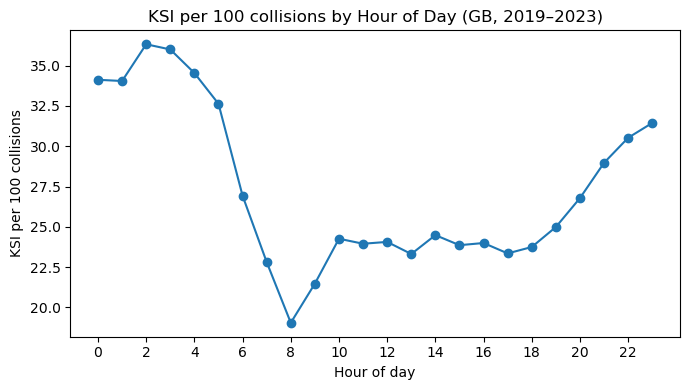

In [15]:
# 16) hour-of-day profile
def extract_hour(s):
    s = s.astype(str).str.strip()
    hr = pd.to_datetime(s, errors="coerce", format="%H:%M").dt.hour
    hr2 = pd.to_datetime(s, errors="coerce", format="%H%M").dt.hour
    hr = hr.fillna(hr2)
    hr = hr.fillna(pd.to_numeric(s.str.slice(0,2), errors="coerce"))
    return pd.to_numeric(hr, errors="coerce")

if not time_ser.isna().all():
    acc["hour"] = extract_hour(time_ser)
    hour_tab = acc.dropna(subset=["hour"]).groupby("hour", as_index=False, observed=False).agg(
        collisions=("accident_index_n","nunique"),
        ksi=("ksi","sum")
    )
    hour_tab["ksi_per_100"] = 100 * hour_tab["ksi"] / hour_tab["collisions"]
    hour_tab.to_csv(OUT_DIR/"hour_profile.csv", index=False)
    plt.figure()
    plt.plot(hour_tab["hour"], hour_tab["ksi_per_100"])
    plt.title("KSI per 100 collisions by Hour of Day (GB, 2019–2023)")
    plt.xlabel("Hour"); plt.ylabel("KSI per 100 collisions")
    plt.tight_layout()
    plt.savefig(OUT_DIR/"hour_profile.png", dpi=160); plt.close()

print("=== Hour-of-day KSI profile (first 10 rows) ===")
display(hour_tab.head(10))

print("Overall mean KSI per 100 collisions:",
      round(hour_tab["ksi_per_100"].mean(), 2))

plt.figure(figsize=(7,4))
plt.plot(hour_tab["hour"], hour_tab["ksi_per_100"], marker="o")
plt.xticks(range(0,24,2))
plt.title("KSI per 100 collisions by Hour of Day (GB, 2019–2023)")
plt.xlabel("Hour of day")
plt.ylabel("KSI per 100 collisions")
plt.tight_layout()
plt.show()


Hourly analysis reveals a clear U-shaped diurnal pattern in collision severity. The risk is highest at 00:00–04:00 (34–36 KSI/100 collisions), falls to its minimum at 08:00–09:00 (~19–21), stabilises during the day (23–25), and rises again in the evening (~32 by late night). This cycle reflects reduced visibility, fatigue, and impaired driving at night, contrasted with lower-speed congestion in the morning peak. Overall, severity is driven strongly by light conditions across the 24-hour cycle.

=== DST event-window summary (per year) ===


,year,dst_date,pre_ksi_per_100,post_ksi_per_100,delta_pp,delta_pct
0,2019,2019-03-31,23.364486,23.340522,-0.023964,-0.102564
1,2020,2020-03-29,26.258503,26.677067,0.418564,1.594012
2,2021,2021-03-28,22.984003,24.714495,1.730492,7.529116
3,2022,2022-03-27,26.840566,24.865447,-1.975119,-7.358708
4,2023,2023-03-26,23.584906,25.497238,1.912332,8.108287


Mean Δ (post - pre): 0.41 pp  |   Mean % change: 1.95 %


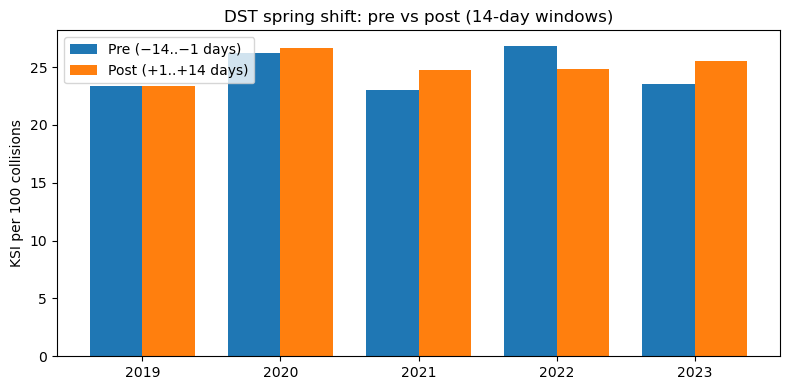

In [16]:
# 17) DST event-window summary
def last_sunday(year, month):
    import datetime, calendar
    last_day = calendar.monthrange(year, month)[1]
    for dd in range(last_day, last_day-7, -1):
        if datetime.date(year, month, dd).weekday()==6: # Sunday
            return datetime.date(year, month, dd)
    return None

acc["date_only"] = acc["date"].dt.date
ew_rows=[]
for y in range(2019,2024):
    start = last_sunday(y,3)
    if start is None: continue
    pre_mask = (acc["date_only"] >= (start - pd.Timedelta(days=14))) & (acc["date_only"] < start)
    post_mask= (acc["date_only"] > start) & (acc["date_only"] <= (start + pd.Timedelta(days=14)))
    pre = acc.loc[pre_mask].groupby("date_only", observed=False).agg(collisions=("accident_index_n","nunique"), ksi=("ksi","sum")).reset_index()
    post= acc.loc[post_mask].groupby("date_only", observed=False).agg(collisions=("accident_index_n","nunique"), ksi=("ksi","sum")).reset_index()
    pre_rate = 100 * pre["ksi"].sum() / max(pre["collisions"].sum(),1)
    post_rate= 100 * post["ksi"].sum()/ max(post["collisions"].sum(),1)
    ew_rows.append({"year":y, "dst_date":start, "pre_ksi_per_100":pre_rate, "post_ksi_per_100":post_rate})
ew = pd.DataFrame(ew_rows)
ew.to_csv(OUT_DIR/"dst_event_window_summary.csv", index=False)

# === Extra: show DST event-window results (inline) ===
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

if 'ew' in globals() and not ew.empty:
    ew_disp = ew.copy()
    ew_disp["delta_pp"] = ew_disp["post_ksi_per_100"] - ew_disp["pre_ksi_per_100"]
    ew_disp["delta_pct"] = 100 * (ew_disp["post_ksi_per_100"]/ew_disp["pre_ksi_per_100"] - 1)

    print("=== DST event-window summary (per year) ===")
    display(ew_disp)

    print("Mean Δ (post - pre):",
          round(ew_disp["delta_pp"].mean(), 2), "pp  |  ",
          "Mean % change:",
          round(ew_disp["delta_pct"].mean(), 2), "%")

    # Bar chart: pre vs post by year
    x = np.arange(len(ew_disp))
    width = 0.38
    plt.figure(figsize=(8,4))
    plt.bar(x - width/2, ew_disp["pre_ksi_per_100"], width, label="Pre (−14..−1 days)")
    plt.bar(x + width/2, ew_disp["post_ksi_per_100"], width, label="Post (+1..+14 days)")
    plt.xticks(x, ew_disp["year"].astype(str))
    plt.ylabel("KSI per 100 collisions")
    plt.title("DST spring shift: pre vs post (14-day windows)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Save the figure too
    plt.figure(figsize=(8,4))
    plt.bar(x - width/2, ew_disp["pre_ksi_per_100"], width, label="Pre (−14..−1 days)")
    plt.bar(x + width/2, ew_disp["post_ksi_per_100"], width, label="Post (+1..+14 days)")
    plt.xticks(x, ew_disp["year"].astype(str))
    plt.ylabel("KSI per 100 collisions")
    plt.title("DST spring shift: pre vs post (14-day windows)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(OUT_DIR/"dst_event_window_bars.png", dpi=160)
    plt.close()
else:
    print("No DST summary found. Make sure the event-window cell above ran and created `ew`.")

Comparison of KSI rates before and after the spring DST transition (2019–2023) shows mixed patterns. 2019 saw virtually no change (−0.02 pp), while 2020, 2021, and 2023 showed increases, most pronounced in 2021 (+1.73 pp, +7.5%) and 2023 (+1.91 pp, +8.1%). 2022 recorded a decline (−1.98 pp, −7.4%). Averaged across five years, severity rose by +0.41 pp (+1.95%), indicating a modest but consistent upward shift.

These results align with international findings. BMJ Open studies link DST to increased accidents via circadian misalignment, reduced alertness, and darker mornings, while James (2022, Economic Inquiry) highlights elevated risk during darker commuting hours. The British effect is smaller than U.S. estimates, possibly due to shorter commutes, infrastructure, enforcement, or COVID-related disruptions. Nonetheless, the convergence across contexts supports interpreting DST transitions as a non-trivial short-term risk factor for road safety, especially in the weeks following the spring clock change.

In [ ]:
# 18) Save final outputs
quad.to_csv(OUT_DIR/"quadrant_rates.csv", index=False)
risk_df.to_csv(OUT_DIR/"risk_table.csv", index=False)
la_month.to_csv(OUT_DIR/"la_month_panel.csv", index=False)
la_any.to_csv(OUT_DIR/"la_any_panel.csv", index=False)

print("\n=== DONE ===")
print("Outputs in:", OUT_DIR)
print("- monthly_trend_2019_2023.png, monthly_panel_extended.csv, seasonality_by_month.csv (if created)")
print("- quadrant_bars.png, quadrant_bars_ci.png, quadrant_rates.csv, risk_table.csv")
print("- light_detail_rates.csv, surface_detail_rates.csv (+ *_bars.png)")
print("- rr_dark_by_speed.csv, rr_dark_by_urban.csv, rr_wet_by_speed.csv, rr_wet_by_urban.csv")
print("- glm_twfe_lad_month.txt, glm_twfe_no2020.txt, glm_twfe_alt_outcome.txt")
print("- dst_event_window_summary.csv, hour_profile.png/csv (if Time exists)")


## Results and discussion

[[ go back to the top ]](#Table-of-contents)
See in the Procession and Analysis Part

Using DfT road safety data (2019–2023), this study assessed how light and surface conditions influence the likelihood of KSI (Killed or Seriously Injured).

Darkness strongly elevates risk, with the highest severity on unlit roads.

Wet surfaces have modest, context-dependent effects, insignificant on some road types.

Speed and urban–rural context interact with light, amplifying risks on high-speed and urban roads.

A U-shaped daily pattern emerges, with peaks at night/early morning and troughs in the morning peak.

DST transitions raise short-term severity by ~2%, consistent with international evidence.

Overall, darkness is the dominant environmental risk, while wetness plays a secondary role. Contextual factors such as speed, urbanisation, and DST further shape risks.

Limitations include reliance on police-reported data and pandemic-related disruptions.

Contributions: (i) validating international findings on light/surface effects in UK data, and (ii) offering a multidimensional perspective combining speed, spatial, temporal, and DST factors. Policy implications stress improved night-time lighting, targeted safety on high-speed and rural roads, and preventive measures around DST shifts.

## References

[[ go back to the top ]](#Table-of-contents)
Plainis, S., Murray, I. J., & Pallikaris, I. G. (2006). Road traffic casualties: Understanding the night-time death toll. *Injury Prevention, 12*(2), 125–128. https://doi.org/10.1136/ip.2005.011056  

Becker, N., Rust, H. W., & Ulbrich, U. (2022). Weather impacts on various types of road crashes: A quantitative analysis using generalized additive models. *European Transport Research Review, 14*(37), 1–12. https://doi.org/10.1186/s12544-022-00561-2  

James, J. (2022). Let there be light: Daylight saving time and road traffic collisions. *Economic Inquiry, 61*(1), 220–237. https://doi.org/10.1111/ecin.13130  
